In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tumour-20250915T133457Z-1-001.zip to Tumour-20250915T133457Z-1-001.zip


In [ ]:
import zipfile
import os

# Extract uploaded file name automatically
zip_filename = list(uploaded.keys())[0]

# Unzip into /content/Tumour
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/Tumour")

# Check extracted contents
print(os.listdir("/content/Tumour"))


['Tumour']


# Step 1 :Understand the Dataset


In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# ✅ Path to TRAIN dataset
dataset_path = "/content/Tumour/Tumour/train"

Tumor Categories: ['meningioma', 'glioma', 'pituitary', 'no_tumor']


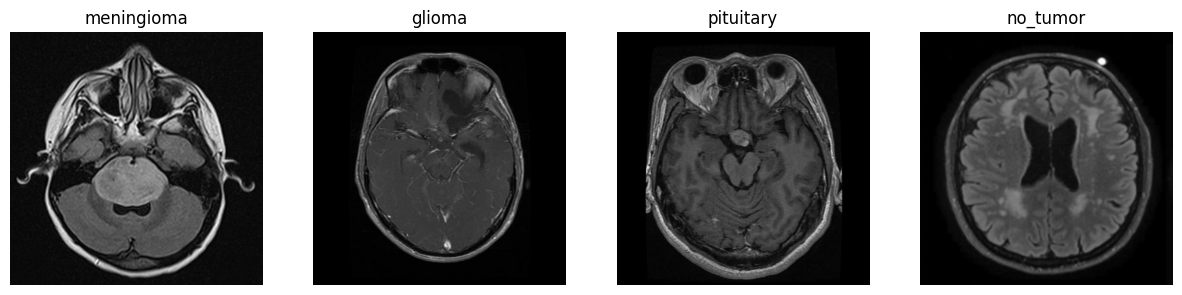

In [ ]:
# 1. Review categories
categories = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
print("Tumor Categories:", categories)

# Helper: get valid image files
def get_image_files(category):
    valid_exts = (".jpg", ".jpeg", ".png", ".tif", ".bmp")
    return [f for f in os.listdir(os.path.join(dataset_path, category)) if f.lower().endswith(valid_exts)]

# --- Show one sample image per category ---
fig, axs = plt.subplots(1, len(categories), figsize=(15,5))
if len(categories) == 1: axs = [axs]

for i, category in enumerate(categories):
    files = get_image_files(category)
    if len(files) > 0:
        img_path = os.path.join(dataset_path, category, random.choice(files))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(category)
        axs[i].axis("off")
    else:
        axs[i].text(0.5, 0.5, "No Images", ha="center", va="center")
        axs[i].set_title(category)
        axs[i].axis("off")
plt.show()

Image counts per class: {'meningioma': 358, 'glioma': 564, 'pituitary': 438, 'no_tumor': 335}


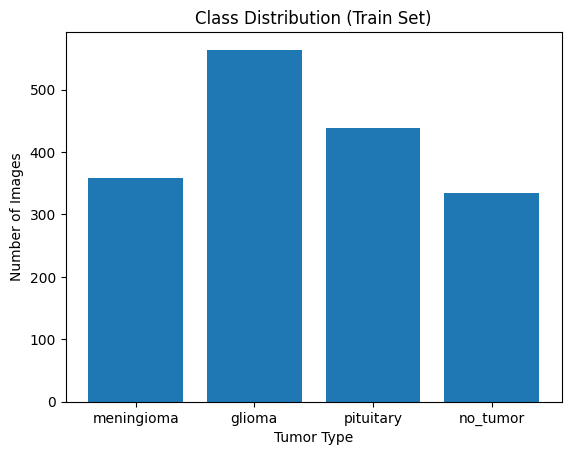

In [ ]:
# 2. Check for class imbalance
counts = [len(get_image_files(c)) for c in categories]
print("Image counts per class:", dict(zip(categories, counts)))

plt.bar(categories, counts)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# 3. Check image resolution consistency
sample_shapes = []
for category in categories:
    files = get_image_files(category)
    if len(files) > 0:
        img_path = os.path.join(dataset_path, category, random.choice(files))
        img = cv2.imread(img_path)
        sample_shapes.append(img.shape)
    else:
        sample_shapes.append(("Empty Folder",))

print("\nSample image resolutions from each class:")
for cat, shape in zip(categories, sample_shapes):
    print(f"{cat}: {shape}")



Sample image resolutions from each class:
meningioma: (640, 640, 3)
glioma: (640, 640, 3)
pituitary: (640, 640, 3)
no_tumor: (640, 640, 3)


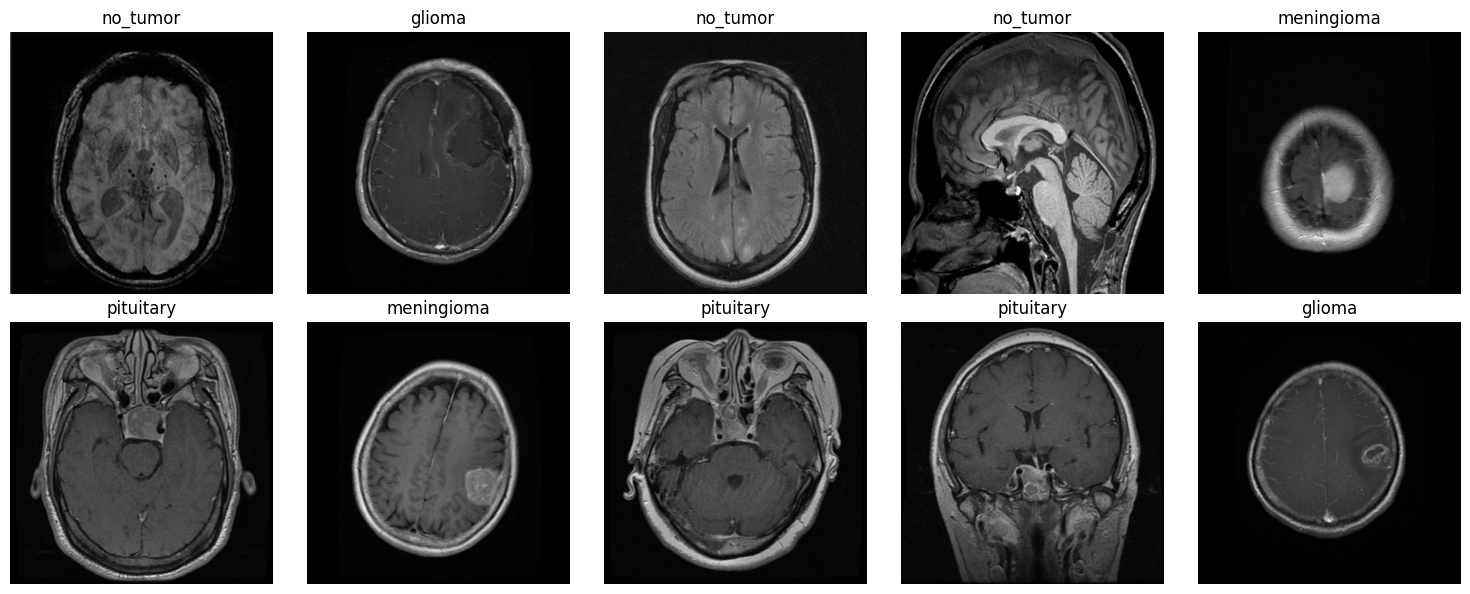

In [ ]:
# 4. Explore image distributions visually (10 random images overall)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for i in range(10):
    category = random.choice(categories)
    files = get_image_files(category)
    if len(files) > 0:
        img_path = os.path.join(dataset_path, category, random.choice(files))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(category)
        axs[i].axis("off")
    else:
        axs[i].text(0.5, 0.5, "No Images", ha="center", va="center")
        axs[i].set_title(category)
        axs[i].axis("off")

plt.tight_layout()
plt.show()

# Step 2 :Data Preprocessing

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Target image size
IMG_SIZE = 224

def load_data(base_path, categories):
    X, y = [], []
    for idx, category in enumerate(categories):
        files = [f for f in os.listdir(os.path.join(base_path, category)) if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".bmp"))]
        for file in files:
            img_path = os.path.join(base_path, category, file)
            img = cv2.imread(img_path)
            if img is None:  # skip if failed to load
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))   # ✅ Resize
            img = img / 255.0                             # ✅ Normalize
            X.append(img)
            y.append(idx)
    return np.array(X), np.array(y)

# Paths
train_path = "/content/Tumour/Tumour/train"
valid_path = "/content/Tumour/Tumour/valid"
test_path  = "/content/Tumour/Tumour/test"

# Categories from train folder
categories = [c for c in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, c))]
print("Categories:", categories)

# Load datasets
X_train, y_train = load_data(train_path, categories)
X_valid, y_valid = load_data(valid_path, categories)
X_test,  y_test  = load_data(test_path, categories)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(categories))
y_valid = to_categorical(y_valid, num_classes=len(categories))
y_test  = to_categorical(y_test,  num_classes=len(categories))

# Shapes
print("Train set:", X_train.shape, y_train.shape)
print("Valid set:", X_valid.shape, y_valid.shape)
print("Test set:",  X_test.shape,  y_test.shape)


Categories: ['meningioma', 'glioma', 'pituitary', 'no_tumor']
Train set: (1695, 224, 224, 3) (1695, 4)
Valid set: (502, 224, 224, 3) (502, 4)
Test set: (246, 224, 224, 3) (246, 4)


# Step 3:Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Only rescale here, don't divide by 255 manually before this
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # rotate images by up to 20 degrees
    width_shift_range=0.2,       # horizontal shift
    height_shift_range=0.2,      # vertical shift
    zoom_range=0.2,              # zoom in/out
    horizontal_flip=True,        # flip images horizontally
    vertical_flip=True,          # flip images vertically
    brightness_range=[0.8, 1.2], # adjust brightness
    fill_mode="nearest"          # fill empty pixels after transformation
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Flow from directories instead of preloading all into memory
train_generator = train_datagen.flow_from_directory(
    "/content/Tumour/Tumour/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/Tumour/Tumour/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    "/content/Tumour/Tumour/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


Visual Check – Augmented Images

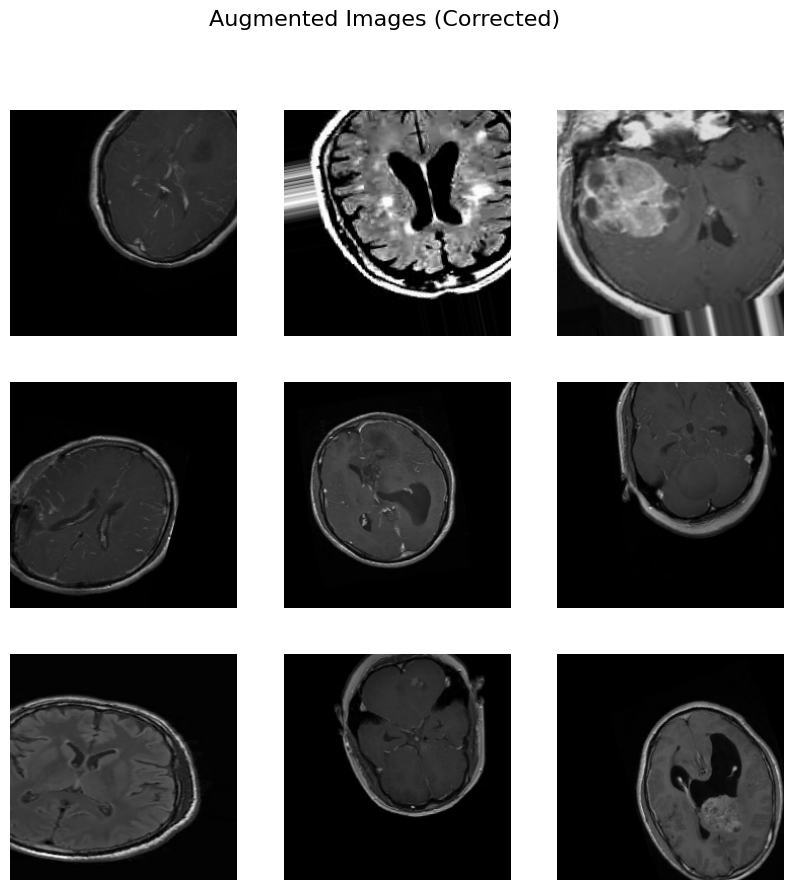

In [ ]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])   # already normalized to [0,1]
    plt.axis("off")
plt.suptitle("Augmented Images (Corrected)", fontsize=16)
plt.show()


# Step 4:Model Building

In [ ]:
# =========================
# Brain Tumor CNN Pipeline
# =========================

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# -------------------------
# 1. Dataset Paths
# -------------------------
train_path = "/content/Tumour/Tumour/train"
valid_path = "/content/Tumour/Tumour/valid"
test_path  = "/content/Tumour/Tumour/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
# -------------------------
# 2. Data Generators
# -------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("Class mapping:", class_indices)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Class mapping: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


In [ ]:
# -------------------------
# 3. Class Weights (for imbalance)
# -------------------------
y_train_classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


In [ ]:
# -------------------------
# 4. Build Custom CNN
# -------------------------
def build_custom_cnn(input_shape=(224,224,3), n_classes=num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.30))

    # Block 3
    model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.35))

    # Head
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation="softmax"))

    return model

model = build_custom_cnn()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 323,876 (1.24 MB)

 Trainable params: 322,468 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# -------------------------
# 5. Callbacks
# -------------------------
cb_early = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
cb_chkpt = ModelCheckpoint("custom_cnn_best.h5", monitor="val_loss", save_best_only=True, verbose=1)
cb_rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)


In [ ]:
# -------------------------
# 6. Training
# -------------------------
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[cb_early, cb_chkpt, cb_rlrop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4832 - loss: 1.5130 
Epoch 1: val_loss improved from inf to 1.41973, saving model to custom_cnn_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 938s 18s/step - accuracy: 0.4846 - loss: 1.5089 - val_accuracy: 0.2351 - val_loss: 1.4197 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6111 - loss: 1.0283 
Epoch 2: val_loss did not improve from 1.41973
53/53 ━━━━━━━━━━━━━━━━━━━━ 923s 17s/step - accuracy: 0.6113 - loss: 1.0289 - val_accuracy: 0.2351 - val_loss: 1.5340 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6244 - loss: 1.0858 
Epoch 3: val_loss did not improve from 1.41973
53/53 ━━━━━━━━━━━━━━━━━━━━ 932s 18s/step - accuracy: 0.6245 - loss: 1.0848 - val_accuracy: 0.2351 - val_loss: 1.6551 - learning_rate: 1.0000e-04
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6655 - loss: 0.9578 
Epoch 4: val_loss did not improve from 1.41973

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
53/53 ━━━━━━━━━━━━━━━━━━━━ 929s 18s/step - accuracy: 0.6654 - loss: 0.9579 - val_accuracy: 0

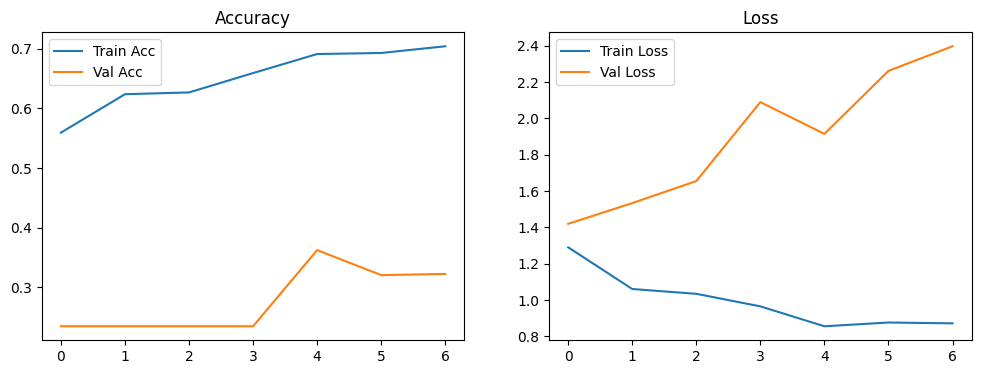

In [ ]:
# -------------------------
# 7. Training Plots
# -------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


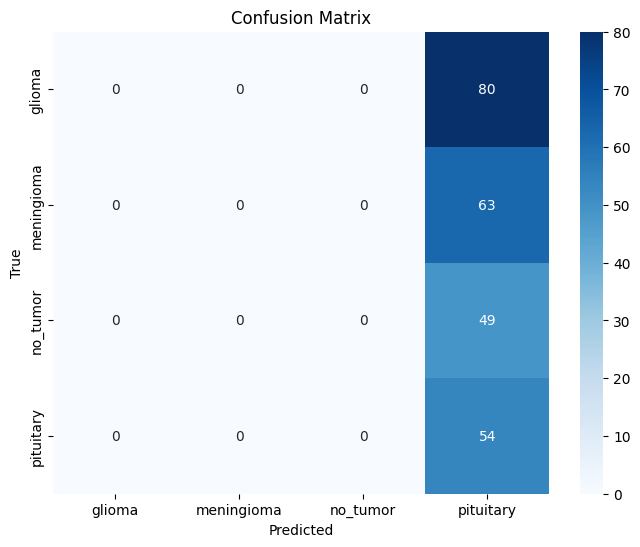

In [ ]:
# -------------------------
# 8. Evaluation on Test Set
# -------------------------
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[inv_class_indices[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[inv_class_indices[i] for i in range(num_classes)],
            yticklabels=[inv_class_indices[i] for i in range(num_classes)],
            cmap="Blues")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("best_custom_cnn.h5")
from google.colab import files
files.download("best_custom_cnn.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 5 :Transfer Learning

In [ ]:
# =========================
# Transfer Learning: ResNet50
# =========================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# -------------------------
# 1. Dataset Generators (reuse previous ones)
# -------------------------
# Make sure you already ran the generator setup earlier
# train_generator, valid_generator, test_generator exist

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
print("Classes:", class_indices)


In [ ]:
# -------------------------
# 2. Build Transfer Learning Model
# -------------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model initially
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(num_classes, activation="softmax")(x)

model_tl = Model(inputs=base_model.input, outputs=preds)

model_tl.compile(optimizer=Adam(learning_rate=1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_tl.summary()

In [ ]:
# -------------------------
# 3. Callbacks
# -------------------------
cb_early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
cb_chkpt = ModelCheckpoint("resnet50_best.h5", monitor="val_loss", save_best_only=True, verbose=1)
cb_rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [ ]:
# -------------------------
# 4. Training (Feature Extraction)
# -------------------------
history_tl = model_tl.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[cb_early, cb_chkpt, cb_rlrop],
    verbose=1
)

In [ ]:
# -------------------------
# 5. Fine-tuning (Optional)
# -------------------------
# Unfreeze last few layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

history_ft = model_tl.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[cb_early, cb_chkpt, cb_rlrop],
    verbose=1
)

In [ ]:
# -------------------------
# 6. Training Curves
# -------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_tl.history["accuracy"] + history_ft.history["accuracy"], label="Train Acc")
plt.plot(history_tl.history["val_accuracy"] + history_ft.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history_tl.history["loss"] + history_ft.history["loss"], label="Train Loss")
plt.plot(history_tl.history["val_loss"] + history_ft.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()


In [ ]:
# -------------------------
# 7. Evaluation on Test Set
# -------------------------
y_pred_probs = model_tl.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print("\nClassification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=[inv_class_indices[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[inv_class_indices[i] for i in range(num_classes)],
            yticklabels=[inv_class_indices[i] for i in range(num_classes)],
            cmap="Blues")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix - ResNet50")
plt.show()

# Step 6 :Model Training

In [ ]:
# =========================================
# Model Training: Custom CNN vs Transfer Learning (ResNet50)
# =========================================

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# -------------------------
# Callbacks
# -------------------------
cb_early = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
cb_rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [ ]:
# -------------------------
# 1. Train Custom CNN
# -------------------------
cnn_chkpt = ModelCheckpoint("best_custom_cnn.h5", monitor="val_loss", save_best_only=True, verbose=1)

history_cnn = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[cb_early, cb_rlrop, cnn_chkpt],
    verbose=1
)

In [ ]:
# -------------------------
# 2. Train Transfer Learning (ResNet50)
# -------------------------
tl_chkpt = ModelCheckpoint("best_resnet50.h5", monitor="val_loss", save_best_only=True, verbose=1)

history_tl = model_tl.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[cb_early, cb_rlrop, tl_chkpt],
    verbose=1
)

In [ ]:
# -------------------------
# 3. Plot Training Curves
# -------------------------
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.legend(); plt.title(f"{title} - Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend(); plt.title(f"{title} - Loss")
    plt.show()

plot_history(history_cnn, "Custom CNN")
plot_history(history_tl, "ResNet50 Transfer Learning")

# Step 7 :Model Evaluation

In [ ]:
# =========================================
# Model Evaluation: Custom CNN & ResNet50
# =========================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# Helper: Evaluate Model
# -------------------------
def evaluate_model(model, test_generator, inv_class_indices, model_name="Model"):
    # Predictions
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Classification report
    print(f"\n📊 Classification Report: {model_name}")
    print(classification_report(y_true, y_pred, target_names=[inv_class_indices[i] for i in range(len(inv_class_indices))]))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=[inv_class_indices[i] for i in range(len(inv_class_indices))],
                yticklabels=[inv_class_indices[i] for i in range(len(inv_class_indices))],
                cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

# -------------------------
# Evaluate both models
# -------------------------
evaluate_model(model, test_generator, inv_class_indices, "Custom CNN")
evaluate_model(model_tl, test_generator, inv_class_indices, "ResNet50 Transfer Learning")

# -------------------------
# Plot Training History
# -------------------------
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.legend(); plt.title(f"{title} - Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend(); plt.title(f"{title} - Loss")
    plt.show()

plot_history(history_cnn, "Custom CNN")
plot_history(history_tl, "ResNet50 Transfer Learning")

# Step 8 :Model Comparison


In [ ]:
# =========================================
# Model Comparison: Custom CNN vs ResNet50
# =========================================

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(model, test_generator, model_name="Model"):
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec  = recall_score(y_true, y_pred, average="weighted")
    f1   = f1_score(y_true, y_pred, average="weighted")

    return {
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-score": round(f1, 4)
    }

# Collect metrics
results = []
results.append(get_metrics(model, test_generator, "Custom CNN"))
results.append(get_metrics(model_tl, test_generator, "ResNet50 Transfer Learning"))

# Create comparison table
df_results = pd.DataFrame(results)
print("\n📊 Model Comparison Table:\n")
print(df_results)

# Visual comparison
df_results.set_index("Model")[["Accuracy","Precision","Recall","F1-score"]].plot(
    kind="bar", figsize=(10,6), rot=0, title="Model Performance Comparison"
)
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
